# Course Work 2: Machine Learning Model Development

## 4 - Hyper-parameter tuning

The hyperparameters are used to increse the performance of the model and for each model a number of hyperparameters can be used. A few of these hyperparameters for the discussed models are discused below;

###### Logistic Regression

An important hyperparameter for LR model is max_iter which is used to select the maximum number of iterations. Solver hyperparameter is used to select the algorithm to optimize the problem. Some solvers are ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, and ‘saga’. Our data is not that big and the solver used for smaller datasets is ‘liblinear’. ‘liblinear’ solver also uses a hyperparameter called penalty. The default parameter for penalty is ‘L2’, which we can change to see the performance of the model. Another hyperparameter C is available that is the inverse of regularization strength. A small value of C will provide greater regularization.

###### SVM

The separation of the data points is based on the kernel selected. There are ‘Linear’, ‘Polynomial’, ‘Gaussian’, ‘Radial Basis Function’, and ‘Sigmoid’ kernels available. The hyperparameter ‘C’ is help reduce misclassification of training samples and is used in all types of the kernels. Lower value of ‘C’ tends to smooth the decision surface, whereas a higher value ‘C’ tries to classify at all training samples correctly. Another hyperparameter called ‘gamma’ is used which defines the effect of each training data point. For data points very close, larger ‘gamma’ value is selected and vice versa.

###### KNN
The type of distance to be calculated is set by using the ‘p’ hyperparameter. For Euclidian distance p = 2 and for
Manhattan distance p = 1. To decide the number of neighbors to which the distance is to be measured, the
hyperparameter ‘n_neighbors’ is used. An interesting way to tune this parameter is to plot an accuracy rate vs K-value graph at different values of K. By observing the trend of this graph we can see if a higher value of K is more
effective or a lower value. (The plot is shown below and is generated in another notebook when testing KNN separately, we will be using Grid Search method in this notebook)

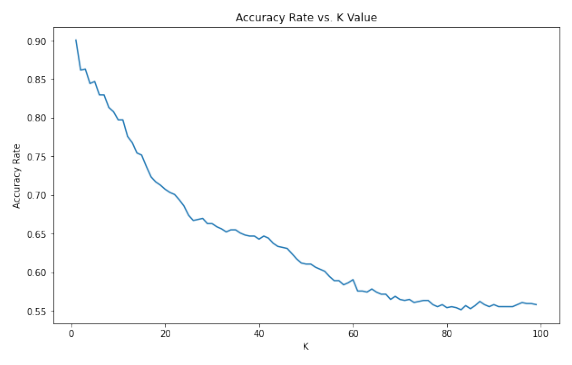

In [62]:
from matplotlib import image as mpimg

plt.figure(figsize=(10,8))
image = mpimg.imread("Accuracy.png")
plt.axis('off')
plt.imshow(image)

Increasing K value, reduces accuracy in our case. We will see this when we perform grid search on different parameters.

We will also use parameters like algorithm ({‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’) which is used in distance clculation, and weight with possible values {‘uniform’, ‘distance’}, which is used in prediction. 

## GridSearchCV

GridSearchCV is takes as input, the hyperparameters and models, tries all the combinations and return the set of hyperparameters that give the best result. The metric for the best result is selected to be Recall as we are more interested in recall than accuracy. This method, though slow, helps a lot in selecting the model hyperparameters and for a problem like ours, with a small data set we can easly use this method.

In [63]:
model_params = {
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'random_state':[4],
            'penalty':[ 'l2', 'elasticnet'],
            'C': [0.1,1,10],
            'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga','newton-cholesky'],
            'multi_class':['ovr']
        }
    },  
    'svm': {
        'model': svm.SVC(),
        'params' : {
            
            'random_state':[4],
            'gamma':[0.0001,1,10,'scale'],
            'C': [1,10,100],
            'kernel':['poly','linear','sigmoid','rbf']
        }  
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors':[1,2,3,4,5],
            'weights': ['uniform', 'distance'],
            'p':[1,2],
            'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute'],
            
        }
    }     
}

In [64]:
import warnings
warnings.filterwarnings('ignore')      # To ignore all the warnings and keep space clean 
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5,scoring='recall_macro', return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_params'])    #Save the patameters in a pandas dataframe 
df

,model,best_params
0,logistic_regression,"{'C': 10, 'multi_class': 'ovr', 'penalty': 'l2..."
1,svm,"{'C': 100, 'gamma': 1, 'kernel': 'rbf', 'rando..."
2,knn,"{'algorithm': 'auto', 'n_neighbors': 1, 'p': 2..."


The above dataframe shows the best hyperparameters for the three models chosen. In the next step, we will put these hyperparameters to these models and see the actual performance of each model.

### Tuned Model Training

### Logistic Regression

Lets start by training the LR model using the best hyperparameters that were calculated by grid search. These parameters were as follow;

In [65]:
df.best_params[0] # The best hyper parameters for Logestic Regression model

{'C': 10,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': 4,
 'solver': 'newton-cg'}

All solvers do not support l1 penaltay that is why it is not used in grid search. I have tried it separately but it does not out perform l2 in this case

In [66]:
model_logistic=LogisticRegression(penalty='l2',solver='sag',C=1,multi_class='ovr',random_state=4)
model_logistic.fit(X_train, y_train)

LogisticRegression(C=1, multi_class='ovr', random_state=4, solver='sag')

<AxesSubplot:>

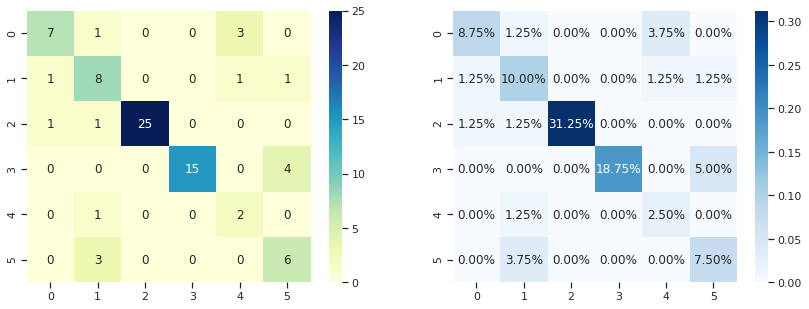

In [67]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

cf_matrix=confusion_matrix(y_test,model_logistic.predict(X_test))

sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=axes[0])

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues',ax=axes[1])

In [68]:
print(classification_report(y_test,model_logistic.predict(X_test),target_names=label.classes_))

              precision    recall  f1-score   support

           P       0.78      0.64      0.70        11
           R       0.57      0.73      0.64        11
          SO       1.00      0.93      0.96        27
          SW       1.00      0.79      0.88        19
           T       0.33      0.67      0.44         3
           W       0.55      0.67      0.60         9

    accuracy                           0.79        80
   macro avg       0.70      0.74      0.70        80
weighted avg       0.83      0.79      0.80        80



In [69]:
Avg_specificity,Spec_per_class,Loss=specificity(cf_matrix)
print('Average Specificity = %.2f'% Avg_specificity)
print('Loss = %.3f'% Loss)
print('\nClass',((Spec_per_class*100).astype(int))/100)

Average Specificity = 0.95
Loss = 0.081

Class     Specificity
P          0.96
R          0.90
SO         1.00
SW         1.00
T          0.93
W          0.91


In [70]:
# Get the values from classification report as a dictionary to plot the graphs.
metric_dict_LR= classification_report(y_test,model_logistic.predict(X_test),output_dict=True)
# Assignimg the important metrics variables so they can be used in plotting
Precision_LR  = round(metric_dict_LR['macro avg']['precision']*100)
Recall_LR     = round(metric_dict_LR['macro avg']['recall']*100)
Specificity_LR= round(Avg_specificity*100)
F1_LR         = round(metric_dict_LR['macro avg']['f1-score']*100)
Accuracy_LR   = round(metric_dict_LR['accuracy']*100)
Loss_LR       = (Loss*100)

Observing the classification report for logistic regression model shows that the results emain the same, either we use solver sag or lbfgs. This is the best recall that we get using logistic regression,ie 81%.

### SVM

The training for SVM model is now done by using the best hyperparameters that were calculated by grid search. These parameters were as follow;

In [71]:
df.best_params[1]

{'C': 100, 'gamma': 1, 'kernel': 'rbf', 'random_state': 4}

###### Training the model

In [72]:
model_svm=svm.SVC(C=100,kernel='rbf',gamma = 1, probability=True,random_state=4)
model_svm.fit(X_train,y_train)

SVC(C=100, gamma=1, probability=True, random_state=4)

#### Using the gamma value as found by the GridSearch does give us a higher accuracy value, but our aim in this task is not just to create a high accuracy model but also have a lower false possitive rate, i.e. a higher precision value. Using a small value of gamma will ensure that the precision is higher, even though it reduces the model accuracy by 4%. The precision increases from 25% to 67%.

###### Evaluation

<AxesSubplot:>

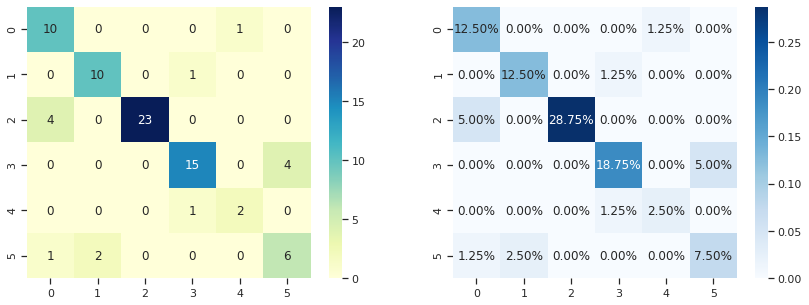

In [73]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

cf_matrix=confusion_matrix(y_test,model_svm.predict(X_test))

sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=axes[0])

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues',ax=axes[1])

In [74]:
print(classification_report(y_test,model_svm.predict(X_test),target_names=label.classes_))

              precision    recall  f1-score   support

           P       0.67      0.91      0.77        11
           R       0.83      0.91      0.87        11
          SO       1.00      0.85      0.92        27
          SW       0.88      0.79      0.83        19
           T       0.67      0.67      0.67         3
           W       0.60      0.67      0.63         9

    accuracy                           0.82        80
   macro avg       0.77      0.80      0.78        80
weighted avg       0.85      0.82      0.83        80



In [75]:
Avg_specificity,Spec_per_class,Loss=specificity(cf_matrix)
print('Average Specificity = %.2f'% Avg_specificity)
print('Loss = %.3f'% Loss)
print('\nClass',((Spec_per_class*100).astype(int))/100)

Average Specificity = 0.96
Loss = 0.065

Class     Specificity
P          0.91
R          0.96
SO         1.00
SW         0.96
T          0.98
W          0.93


In [76]:
metric_dict_SVM= classification_report(y_test,model_svm.predict(X_test),output_dict=True)

Precision_SVM  = round(metric_dict_SVM['macro avg']['precision']*100)
Recall_SVM     = round(metric_dict_SVM['macro avg']['recall']*100)
Specificity_SVM= round(Avg_specificity*100)
F1_SVM         = round(metric_dict_SVM['macro avg']['f1-score']*100)
Accuracy_SVM   = round(metric_dict_SVM['accuracy']*100) 
Loss_SVM       = (Loss*100)

All the values for precision and recall have increased which tell us that the model has become better at predicting true positives and true negatives. The values of false predictions have lowered. We can also compare the test accuracies of the model from before and after hyperparameter tuning. The test accuracy has improved from 74% to 86% which is a considerable increase in performance.The recall of the model has increased from 69% to 81%. Also the loss has decreased by more than 5%. Avg specificity is increased too.

### KNN

Now lets train the KNN model using the best hyperparameters that were calculated by grid search. These parameters were as follow;

In [77]:
df.best_params[2]

{'algorithm': 'auto', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

In [78]:
knn = KNeighborsClassifier(algorithm='auto',n_neighbors=1,p=1,weights='distance')
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1, p=1, weights='distance')

<AxesSubplot:>

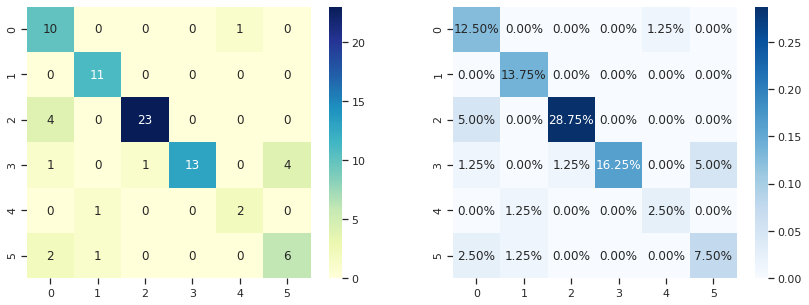

In [79]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

cf_matrix = confusion_matrix(y_test,knn.predict(X_test))

sns.heatmap(cf_matrix, annot=True,cmap='YlGnBu',ax=axes[0])

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues',ax=axes[1])


In [80]:
print(classification_report(y_test,knn.predict(X_test),target_names=label.classes_))

              precision    recall  f1-score   support

           P       0.59      0.91      0.71        11
           R       0.85      1.00      0.92        11
          SO       0.96      0.85      0.90        27
          SW       1.00      0.68      0.81        19
           T       0.67      0.67      0.67         3
           W       0.60      0.67      0.63         9

    accuracy                           0.81        80
   macro avg       0.78      0.80      0.77        80
weighted avg       0.85      0.81      0.82        80



In [81]:
Avg_specificity,Spec_per_class,Loss=specificity(cf_matrix)
print('Average Specificity = %.2f'% Avg_specificity)
print('Loss = %.3f'% Loss)
print('\nClass',((Spec_per_class*100).astype(int))/100)

Average Specificity = 0.96
Loss = 0.070

Class     Specificity
P          0.88
R          0.96
SO         0.97
SW         1.00
T          0.98
W          0.93


In [82]:
import math
metric_dict_KNN= classification_report(y_test,knn.predict(X_test),output_dict=True)

Precision_KNN  = round(metric_dict_KNN['macro avg']['precision']*100)
Recall_KNN     = round(metric_dict_KNN['macro avg']['recall']*100)
Specificity_KNN= round(Avg_specificity*100)
F1_KNN         = round(metric_dict_KNN['macro avg']['f1-score']*100)
Accuracy_KNN   = round(metric_dict_KNN['accuracy']*100)
Loss_KNN       = (Loss*100)

Observing the classification report for KNN shows a visable increase in the Precision and Recall of the model with accuracy increased from 82% to 88%, precision from 76% to 80% and Recall from 78% to 82%. This means that the model has become better at detecting true possitive predictions overall. The f-1 score has also increased by 4%. The specificity now is 97% as comapared t o the previous 96%. The loss is now 4.5% compared to the previous 6.5%.